In [1]:
import numpy as np
import random as rand
import pandas as pd

import diff_classifier.msd as msd
import matplotlib.pyplot as plt
import diff_classifier.heatmaps as hm

In [8]:
import diff_classifier.aws as aws

In [ ]:
msd.random_traj_dataset()

In [ ]:
zeros = np.zeros((512,512)) == 0

In [ ]:
zeros

In [2]:
def checkerboard_mask(dims=(512,512), squares=50, width=25):
    """Creates a 2D Boolean checkerboard mask
    
    Creates a Boolean array of evenly spaced squares.
    Whitespace is set to True.
    
    Parameters
    ----------
    
    dims : tuple of int
        Dimensions of desired Boolean array
    squares : int
        Dimensions of in individual square in array
    width : int
        Dimension of spacing between squares
        
    Returns
    ----------
    
    zeros : numpy.ndarray of bool
        2D Boolean array of evenly spaced squares
    
    """
    zeros = np.zeros(dims) == 0
    square_d = squares

    loy = width
    hiy = loy + square_d

    for j in range(50):

        lox = width
        hix = lox + square_d
        for i in range(50):

            if hix < 512 and hiy < 512:
                zeros[loy:hiy, lox:hix] = False
            elif hix < 512:
                zeros[loy:512-1, lox:hix] = False
            elif hiy < 512:
                zeros[loy:hiy, lox:512-1] = False
            else:
                zeros[loy:512-1, lox:512-1] = False
                break

            lox = hix + width
            hix = lox + square_d

        loy = hiy + width
        hiy = loy + square_d
        
    return zeros

In [ ]:
checkerboard_mask().dtype

In [ ]:
checkerboard_mask().shape

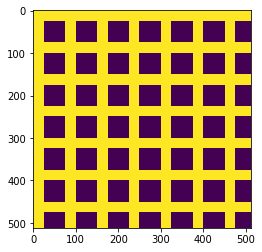

In [84]:
plt.imshow(checkerboard_mask())

In [6]:
from scipy.ndimage.morphology import distance_transform_edt as eudist

In [ ]:
euzeros = eudist(~zeros)
plt.imshow(euzeros)

In [55]:
def random_walk(nsteps=100, seed=None, start=(0, 0), step=1, mask = None, stuckprob = 0.5):
    if type(mask) is np.ndarray:
        while not mask[start[0], start[1]]:
            start = (start[0], start[1]-1)
    
    np.random.seed(seed=seed)

    x = np.zeros(nsteps)
    y = np.zeros(nsteps)
    x[0] = start[0]
    y[0] = start[1]
    eumask = eudist(~mask)

    if not type(mask) is np.ndarray: #Checks to see if a mask is being used first
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            if val == 1:
                x[i] = x[i - 1] + step
                y[i] = y[i - 1]
            elif val == 2:
                x[i] = x[i - 1] - step
                y[i] = y[i - 1]
            elif val == 3:
                x[i] = x[i - 1]
                y[i] = y[i - 1] + step
            else:
                x[i] = x[i - 1]
                y[i] = y[i - 1] - step
    else:
        #print("Applied mask")
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            # Makes sure within mask dimensions
            if x[i-1] > mask.shape[0] - 1:
                x[i-1] = mask.shape[0] - 1
            elif y[i-1] > mask.shape[0] - 1:
                y[i-1] = mask.shape[0] - 1
        
            if mask[int(x[i-1]), int(y[i-1])]: #If mask is being used, checks if entry is in mask or not
                if val == 1:
                    x[i] = x[i - 1] + step
                    y[i] = y[i - 1]
                elif val == 2:
                    x[i] = x[i - 1] - step
                    y[i] = y[i - 1]
                elif val == 3:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] + step
                else:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] - step
            elif np.random.rand() > stuckprob: #If it does cross into a False area, probability to be stuck
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                
                
                while eumask[int(x[i]), int(y[i])] > 0:
                    vals = np.zeros(4)
                    vals[0] = eumask[int(x[i] + step), int(y[i])]
                    vals[1] = eumask[int(x[i] - step), int(y[i])]
                    vals[2] = eumask[int(x[i]), int(y[i] + step)]
                    vals[3] = eumask[int(x[i]), int(y[i] - step)]
                    vali = np.argmin(vals)
                    
                    if vali == 0:
                        x[i] = x[i] + step
                        y[i] = y[i]
                    elif vali == 1:
                        x[i] = x[i] - step
                        y[i] = y[i]
                    elif vali == 2:
                        x[i] = x[i]
                        y[i] = y[i] + step
                    else:
                        x[i] = x[i]
                        y[i] = y[i] - step

            else: #Otherwise, particle is stuck on "cell"
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                

    return x, y

In [69]:
def random_traj_dataset(nframes=100, nparts=30, seed=1, fsize=(0, 512),
                        step=1, mask=None, stuckprob=0.5, ndist=None):
    """Creates a random population of random walks.

    Parameters
    ----------
    nframes : int
        Number of frames for each random trajectory.
    nparts : int
        Number of particles in trajectory dataset.
    seed : int
        Seed for pseudo-random number generator for reproducability.
    fsize : tuple of int or float
        Scope of points over which particles may start at.
    ndist : tuple of int or float
        Parameters to generate normal distribution, mu and sigma.

    Returns
    -------
    dataf : pandas.core.frame.DataFrame
        Trajectory data containing a 'Frame', 'Track_ID', 'X', and
        'Y' column.

    """

    frames = []
    trackid = []
    x = []
    y = []
    start = [0, 0]
    pseed = seed

    for i in range(0, nparts+1):
        rand.seed(a=i+pseed)
        start[0] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+3+pseed)
        start[1] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+5+pseed)
        if type(ndist) is tuple:
            weight = rand.normalvariate(mu=ndist[0], sigma=ndist[1])
        else:
            weight = 1

        trackid = np.append(trackid, np.array([i]*nframes))
        xi, yi = random_walk(nsteps=nframes, seed=i,
                             start=(start[0], start[1]),
                             step=step+weight , mask=mask,
                             stuckprob=stuckprob)
        x = np.append(x, xi)
        y = np.append(y, yi)
        frames = np.append(frames, np.linspace(0, nframes-1, nframes))

    datai = {'Frame': frames,
             'Track_ID': trackid,
             'X': x,
             'Y': y,
             'Quality': (nframes)*(nparts+1)*[10],
             'SN_Ratio': (nframes)*(nparts+1)*[0.1],
             'Mean_Intensity': (nframes)*(nparts+1)*[120]}
    
    print(len(frames))
    print(len(trackid))
    print(x.shape)
    print(y.shape)
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    dataf = pd.DataFrame(data=datai)

    return dataf

In [50]:
random_walk(mask = checkerboard_mask(dims=(514,514), width=9), stuckprob = 0.5)

(array([  0.,  -1.,  -2.,  -3.,  -4.,  -5.,  -5.,  -4.,  -3.,  -3.,  -2.,
         -2.,  -3.,  -3.,  -4.,  -5.,  -6.,  -7.,  -7.,  -6.,  -5.,  -5.,
         -6.,  -5.,  -6.,  -6.,  -6.,  -5.,  -6.,  -6.,  -6.,  -5.,  -5.,
         -6.,  -6.,  -5.,  -6.,  -6.,  -6.,  -6.,  -5.,  -4.,  -5.,  -5.,
         -6.,  -7.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9., -10.,  -9., -10.,
        -11., -12., -12., -12., -12., -11., -11., -11., -11., -11., -12.,
        -11., -11., -11., -11., -11., -11., -12., -12., -12., -12., -12.,
        -12., -13., -13., -12., -11., -12., -12., -11., -10., -11., -11.,
        -11., -11., -10.,  -9.,  -8.,  -9.,  -9.,  -9.,  -9.,  -9., -10.,
         -9.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
         2.,  2.,  2.,  3.,  4.,  4.,  3.,  3.,  2.,  2.,  2.,  1.,  2.,
         1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1., -2.,
        -2., -2., -2., -2.

In [76]:
bucket = 'ccurtis.data'
folder = 'test'
names = []

geomean = {}
gSEM = {}

counter = 1
for i in [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]:
    dataf = random_traj_dataset(nframes=200, nparts=500, mask=checkerboard_mask(dims=(514,514), width=9), stuckprob=i)
    sample_name = 'stuck_narrow_{}'.format(counter)
    dataf.to_csv('Traj_{}.csv'.format(sample_name))
    msds = msd.all_msds(dataf)
    filename = 'msd_{}.csv'.format(sample_name)
    msds.to_csv(filename)
    
    names.append(sample_name)
    aws.upload_s3(filename, '{}/{}'.format(folder, filename), bucket_name=bucket)
    geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=1, fps=1,
                                                                 remote_folder=folder, bucket=bucket)
    
    counter += 1

100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200
100200
100200
(100200,)
(100200,)
100200
100200
100200


In [81]:
# Second quick fix
counter = 1
for i in [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]:
    sample_name = 'stuck_narrow_{}'.format(counter)
    prefix = sample_name
    umppx = 1
    fps = 1
    merged = pd.read_csv('msd_{}.csv'.format(prefix))
    particles = int(max(merged['Track_ID']))
    frames = int(max(merged['Frame']))
    ypos = np.zeros((particles+1, frames))

    for i in range(0, particles+1):
        ypos[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        xpos = merged.loc[merged.Track_ID == i, 'Frame']/fps

    geo_mean = np.nanmean(ma.log(ypos), axis=0)
    geo_stder = ma.masked_equal(stats.sem(ma.log(ypos), axis=0,
                                          nan_policy='omit'), 0.0)

    np.savetxt('geomean_{}.csv'.format(prefix), geo_mean, delimiter=",")
    np.savetxt('geoSEM_{}.csv'.format(prefix), geo_stder, delimiter=",")
    counter += 1

In [64]:
merged

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss
0,0,1.0,1.0,139.0,241.0,0.000000,0.000000
1,1,2.0,1.0,139.0,239.0,4.000000,0.500000
2,2,3.0,1.0,139.0,241.0,6.862944,0.788041
3,3,4.0,1.0,141.0,241.0,8.979592,0.836240
4,4,5.0,1.0,143.0,241.0,11.364103,0.850738
5,5,6.0,1.0,141.0,241.0,14.144330,0.791919
6,6,7.0,1.0,141.0,239.0,17.202073,0.780237
7,7,8.0,1.0,141.0,241.0,19.166667,0.842042
8,8,9.0,1.0,141.0,243.0,21.486911,0.838808
9,9,10.0,1.0,143.0,243.0,23.284211,0.783929


In [80]:
# Quick fix
geomean = {}
gSEM = {}
backup_frames = 200

counter = 1
for i in [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]:
    sample_name = 'stuck_narrow_{}'.format(counter)
    filename = 'msd_{}.csv'.format(sample_name)
    msds = pd.read_csv(filename, index_col='Unnamed: 0')
    print(msds.head())
    msds['Track_ID'] = msds['Track_ID'] - 1
    msds.to_csv(filename)
    print(msds.head())
    aws.upload_s3(filename, '{}/{}'.format(folder, filename), bucket_name=bucket)
    geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=1, fps=1,
                                                                 remote_folder=folder, bucket=bucket)
    
    counter += 1

   Frame  Track_ID      X      Y       MSDs     Gauss
0    1.0       1.0  139.0  241.0   0.000000  0.000000
1    2.0       1.0  139.0  239.0   4.000000  0.500000
2    3.0       1.0  139.0  241.0   6.862944  0.788041
3    4.0       1.0  141.0  241.0   8.979592  0.836240
4    5.0       1.0  143.0  241.0  11.364103  0.850738
   Frame  Track_ID      X      Y       MSDs     Gauss
0    1.0       0.0  139.0  241.0   0.000000  0.000000
1    2.0       0.0  139.0  239.0   4.000000  0.500000
2    3.0       0.0  139.0  241.0   6.862944  0.788041
3    4.0       0.0  141.0  241.0   8.979592  0.836240
4    5.0       0.0  143.0  241.0  11.364103  0.850738
   Frame  Track_ID      X      Y       MSDs     Gauss
0    1.0       1.0  139.0  241.0   0.000000  0.000000
1    2.0       1.0  139.0  239.0   3.939394  0.507692
2    3.0       1.0  139.0  241.0   6.903553  0.770277
3    4.0       1.0  141.0  241.0   9.244898  0.818064
4    5.0       1.0  143.0  241.0  11.938462  0.889441
   Frame  Track_ID      X   

In [35]:
geomean = {}
gSEM = {}
counter = 1
for i in [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]:
    sample_name = 'stuck_{}'.format(counter)
    geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=1, fps=1,
                                                                 remote_folder=folder, bucket=bucket)
    print(geomean[sample_name][0:10])
    counter += 1

[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]


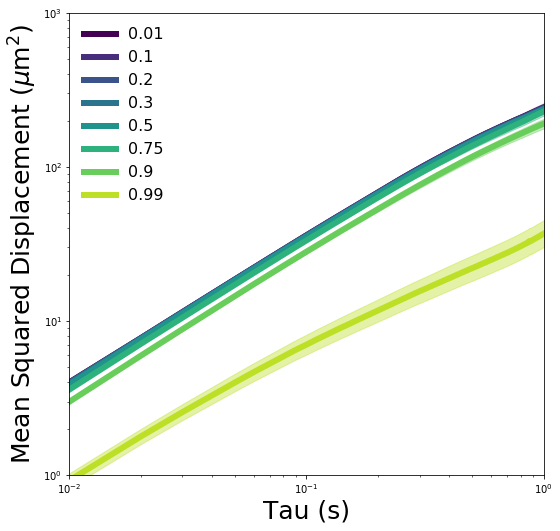

In [48]:
msd.plot_all_experiments(names,
                         yrange=(10**-0, 10**3), bucket=bucket, folder=folder,
                         labels = [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99])

In [82]:
names

['stuck_narrow_1',
 'stuck_narrow_2',
 'stuck_narrow_3',
 'stuck_narrow_4',
 'stuck_narrow_5',
 'stuck_narrow_6',
 'stuck_narrow_7',
 'stuck_narrow_8']

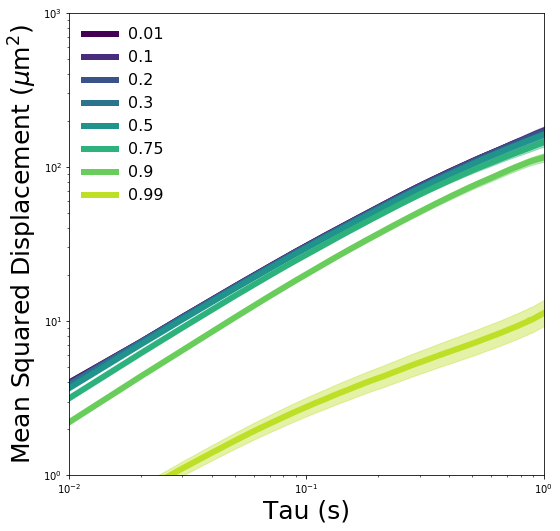

In [83]:
msd.plot_all_experiments(names,
                         yrange=(10**-0, 10**3), bucket=bucket, folder=folder,
                         labels = [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99])

(0, 512)

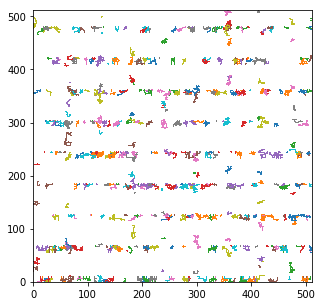

In [87]:
fig, ax = plt.subplots(figsize=(5,5))
for i in range(499):
    ax.plot(dataf[dataf['Track_ID']==i]['X'], dataf[dataf['Track_ID']==i]['Y'], linewidth=1)
ax.set_xlim([0, 512])
ax.set_ylim([0, 512])

In [ ]:
vals = np.array([1, 2, 3, 4])
np.argmin(vals)

In [ ]:
start = (256, 256)
while not zeros[start[0], start[1]]:
    start = (start[0], start[1]+1)
print(start)

xs, ys = random_walk(start=(256, 256), step=0.75, mask=zeros, stuckprob=0.1)
plt.plot(xs, ys, linewidth=5)
plt.xlim([0, 512])
plt.ylim([0, 512])

In [ ]:
xs

In [ ]:
ys

In [ ]:
x, y

In [ ]:
xs, ys = random_walk()
xs = xs*0.1 + np.random.randint(low=0, high=512-1)
ys = ys*0.1 + np.random.randint(low=0, high=512-1)

counter = True
for x, y in zip(xs.astype(int), ys.astype(int)):
    if not zeros[x, y]:
        counter = False
print(counter)

In [20]:
names = []
for i, j in enumerate([0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]):
    sample_name = 'stuck_narrow_{}'.format(i+1)
    names.append(sample_name)
    print(sample_name)

stuck_narrow_1
stuck_narrow_2
stuck_narrow_3
stuck_narrow_4
stuck_narrow_5
stuck_narrow_6
stuck_narrow_7
stuck_narrow_8


In [21]:
import numpy.ma as ma
geo = {}
gstder = {}
counter = 0
for counter, experiment in enumerate(names):

    geo[counter] = np.genfromtxt('geomean_{}.csv'.format(experiment))
    gstder[counter] = np.genfromtxt('geoSEM_{}.csv'.format(experiment))
    geo[counter] = ma.masked_equal(geo[counter], 0.0)
    gstder[counter] = ma.masked_equal(gstder[counter], 0.0)
    if counter == 0:
        normalize = np.exp(geo[counter][100])
    
    print('Experiment {0}: {1:0.2f}'.format(experiment, normalize/np.exp(geo[counter][100]) - 1))

Experiment stuck_narrow_1: 0.00
Experiment stuck_narrow_2: -0.01
Experiment stuck_narrow_3: 0.00
Experiment stuck_narrow_4: 0.04
Experiment stuck_narrow_5: 0.05
Experiment stuck_narrow_6: 0.18
Experiment stuck_narrow_7: 0.47
Experiment stuck_narrow_8: 14.07


In [16]:
names = []
for i, j in enumerate([0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99]):
    sample_name = 'stuck_{}'.format(i+1)
    names.append(sample_name)
    print(sample_name)

stuck_1
stuck_2
stuck_3
stuck_4
stuck_5
stuck_6
stuck_7
stuck_8


In [19]:
geo = {}
gstder = {}
for counter, experiment in enumerate(names):

    geo[counter] = np.genfromtxt('geomean_{}.csv'.format(experiment))
    gstder[counter] = np.genfromtxt('geoSEM_{}.csv'.format(experiment))
    geo[counter] = ma.masked_equal(geo[counter], 0.0)
    gstder[counter] = ma.masked_equal(gstder[counter], 0.0)
    
    if counter == 0:
        normalize = np.exp(geo[counter][100])
    
    print('Experiment {0}: {1:0.3f}'.format(experiment, normalize/np.exp(geo[counter][100]) - 1))

Experiment stuck_1: 0.000
Experiment stuck_2: -0.001
Experiment stuck_3: 0.006
Experiment stuck_4: 0.020
Experiment stuck_5: 0.019
Experiment stuck_6: 0.054
Experiment stuck_7: 0.267
Experiment stuck_8: 5.562
